In [1]:
%%capture
#mutes cell output
#%pylab inline
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import display
#from bqplot import pyplot as bgplt

import os
import SFG2D
import pandas as pd
import seaborn as sns
import ipywidgets as ipyw

plt.style.use('seaborn-talk')
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Import Data

## Select Data

In [2]:
""" Global variables init"""
ffolder = '../../../MeasurmentData/2016/08/01/'
ffiles = glob(ffolder + '/*.dat')
# We dont the net AVG files
ffiles = [ x for x in ffiles if "AVG" not in x ]

fnames = [os.path.split(ffile)[1] for ffile in ffiles]

ir = None # IR Spectral Data
pump = None # Pump Spectra
base = None # Background Spectrum
ts0 = None # TimeSeries
ts0u = None # Unnormalized TimeSeries

"""register widgets and observers"""
w_ir_fpath = ipyw.Select(options=fnames, description='IR Profile',
             value = '09_sc_quartz_w674_gcm_e10s_ssp_pu0_pr1_vis1_gal1_chop1_purge1.dat')
w_ir_fbase = ipyw.Select(options=fnames, description='IR Base',
                  value = '08_sp_gold_w674_gcm_e1s_ppp_pu0_pr0_vis1_gal1_chop1_purge1.dat')
w_ir_spec = ipyw.Select(options = ["All", "spec_0", "spec_1", "spec_2"], description="Spectrum", value="spec_1")


w_pump_fpath = ipyw.Select(options=fnames, description='Pump SFG', 
                value = '04_ts_quartz_w674_gcm_e10s_ssp_pu1_pr0_vis1_gal0_chop0_purge1.dat')
def pump_plot_update(change):
    pump_plot(w_pump_spec.value, w_pump_ppdelay.value)
    
w_pump_fpath.observe(pump_plot_update, names="value")
w_pump_fbase = ipyw.Select(options=fnames, description='Pump Base',
                    value = '05_sc_quartz_w674_gcm_e10s_ssp_pu0_pr1_vis1_gal0_chop0_purge1.dat')
w_pump_spec = ipyw.Select(options = ["All", "spec_0", "spec_1", "spec_2"], description="Spectrum", value="spec_1")
w_pump_ppdelay = ipyw.SelectionSlider(continuous_update=False)

w_ts0_fpath = ipyw.Select(options=fnames, description='Pump Probe',
                        value = '15_ts_na2s04-002_w674_gcm_e10m_ssp_pu1_pr1_vis1_gal1_chop1_purge1_chil10.dat')
def pump_probe_plot_update(change):
    pump_probe_plot(w_ts0_ppdelay0.value)
    
w_ts0_fpath.observe(pump_probe_plot_update, names="value")
w_ts0_pumped = ipyw.Dropdown(options = ["spec_0", "spec_1", "spec_2"], description="pumped", value="spec_0")
w_ts0_probed = ipyw.Dropdown(options = ["spec_0", "spec_1", "spec_2"], description="probed", value="spec_1")
def ts0_pumped_update(change):
    ts0._pumped = w_ts0_pumped.value
    if isinstance(ts0._df.get("bleach"), pd.core.series.Series):
        ts0.df.drop('bleach', axis=1, inplace=True)
    
def ts0_proped_update(change):
    ts0._probed = w_ts0_probed.value
    if isinstance(ts0._df.get("bleach"), pd.core.series.Series):
        ts0.df.drop('bleach', axis=1, inplace=True)
    
w_ts0_pumped.observe(ts0_pumped_update, names="value")
w_ts0_probed.observe(ts0_proped_update, names="value")
w_ts0_ppdelay0 = ipyw.SelectionSlider(continuous_update=False)
w_ts0_ppdelay1 = ipyw.SelectionSlider(continuous_update=False)
w_ts0_ppdelay2 = ipyw.SelectionSlider(continuous_update=False)
w_ts0_ppdelay3 = ipyw.SelectionSlider(continuous_update=False)

w_fbase = ipyw.Select(options=fnames, description='Baseline',
                        value = '11_sc_quartz_w674_gcm_e10m_ssp_pu0_pr0_vis1_gal1_chop1_purge1.dat')

w_sum_button = ipyw.Button(description='Update')

## IR Profile

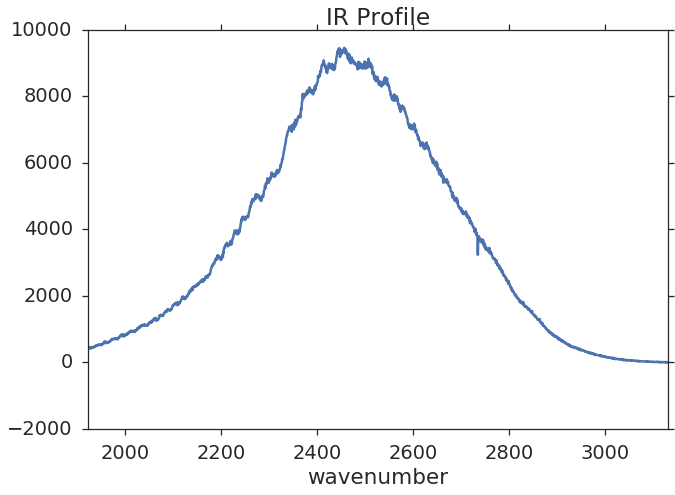

In [3]:
# These functions have strings as input,
# Then there form becomes unclear
# and at the end they need to return a spectrum  object with
# well defined form.
def get_ir(fpath, fbase, spec):
    global ir
    ir = SFG2D.io.veronica.get_scan(ffolder + fpath, ffolder + fbase)
    #base = SFG2D.io.veronica.read_auto(fbase).med
    
    if isinstance(ir, SFG2D.core.scan.TimeScan):
        raise NotImplementedError
    
    if isinstance(ir, SFG2D.core.scan.Scan):
        # background doesnt fit well.
        ir._df -= 40 
        ir.base =+ 40 
        
        #ir.df.drop("pixel", inplace=True, axis=1)
        if spec is "All":
            ir.df.plot()
        else:
            ir.med[spec].plot()
        plt.title("IR Profile")
        plt.draw()

w_ir = ipyw.interactive(get_ir, fpath=w_ir_fpath, fbase = w_ir_fbase, spec=w_ir_spec )
display(w_ir)
plt.show()

## Pump Profile

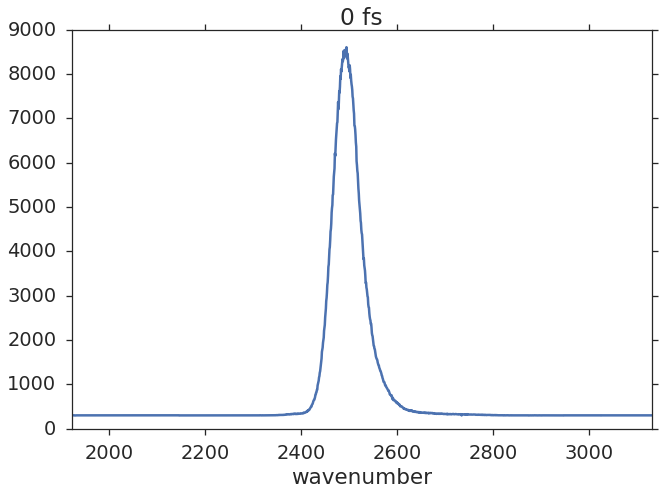

In [4]:
def get_pump(fpath):
    global pump, w_pump_ppdelay
    pump = SFG2D.io.veronica.read_auto(ffolder + fpath)
    
    if isinstance(pump, SFG2D.core.scan.Scan):
        raise NotImplementedError
    
    if isinstance(pump, SFG2D.core.scan.TimeScan):
        w_pump_ppdelay.options = list(pump.pp_delays)
        w_pump_ppdelay.value = 0

def pump_plot(spec, pp_delay):
    
    if spec == "All":
        pump.med.ix[pp_delay].plot()
    else:
        pump.med.ix[pp_delay, spec].plot()
    plt.title('%i fs'%pp_delay)
    plt.draw()

    
    
w_pump = ipyw.interactive(get_pump, fpath = w_pump_fpath)
display(w_pump)

w_pump_plot = ipyw.interactive(pump_plot, spec=w_pump_spec, pp_delay=w_pump_ppdelay)
#w_pump_fpath.observe(w_pump, names='value')

display(w_pump_plot)
plt.show()

## Pump-Probe Data

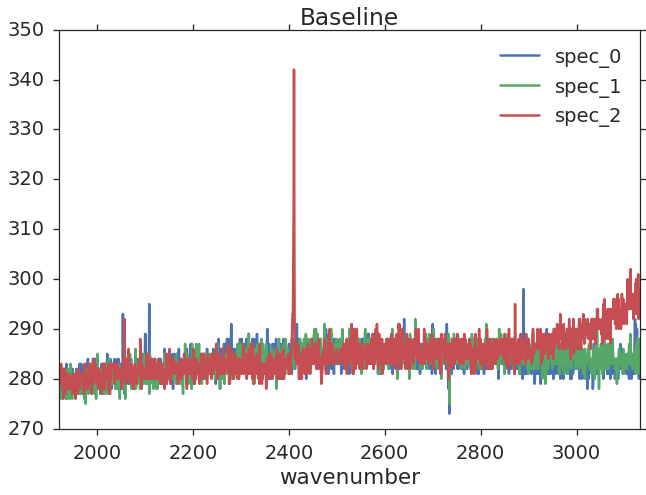

In [5]:
def get_base(fbase):
    global base
    base = SFG2D.io.veronica.read_auto(ffolder + fbase)
    base.med.plot()
    plt.title("Baseline")
    plt.draw()


w_base = ipyw.interactive(get_base, fbase = w_fbase)
display(w_base)
plt.show()

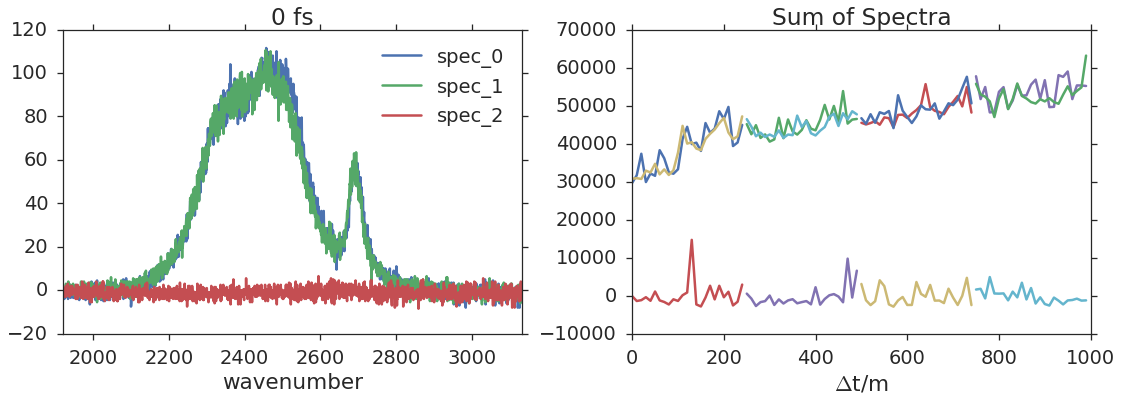

In [7]:
def get_pump_probe(fpath):
    global ts0, ts0u, w_ts0_ppdelay0
    ts0 = SFG2D.io.veronica.read_auto(ffolder + fpath)
    ts0.base = base.med
    ts0.sub_base(inplace=True)
    if w_ir_spec.value is "All":
        ts0.norm = ir.med
    else:
        ts0.norm = ir.med[w_ir_spec.value]
    ts0u = ts0.__deepcopy__()
    ts0.normalize(inplace=True)
    w_ts0_ppdelay0.options=list(ts0.pp_delays)
    w_ts0_ppdelay0.value=0
    w_ts0_ppdelay1.options=w_ts0_ppdelay0.options
    w_ts0_ppdelay1.value=0
    w_ts0_ppdelay2.options=w_ts0_ppdelay0.options
    w_ts0_ppdelay2.value=0
    w_ts0_ppdelay3.options=w_ts0_ppdelay0.options
    w_ts0_ppdelay3.value=0
    
def ts0_pump_update(*args):
    global ts0
    ts0._pumped = w_ts0_pumped.value
    ts0u._pumped = w_ts0_pumped.value
    
def ts0_probe_update(*args):
    global ts0
    ts0._probed = w_ts0_probed.value
    ts0u._probed = w_ts0_probed.value
    
def pump_probe_sum_plot(*args):
    ax = axes_pump_probe_get[1]
    [SFG2D.plotting.ts.sum_of_spectra(ts0u, spec, ax) for spec in ('spec_0', 'spec_1', 'spec_2')]
    ax.set_title("Sum of Spectra")
    #display(fig_pump_probe_get)

def pump_probe_plot(pp_delay):
    ax = axes_pump_probe_get[0]
    ax.clear()
    ts0u.med.ix[pp_delay].plot(ax=ax)
    ax.set_title("%i fs"%pp_delay)
    #plt.ylim(-0.002, 0.015) # get this from data
    #plt.xlim(2100, 2800) # get this from ir profile
    fig_pump_probe_get.tight_layout()
    display(fig_pump_probe_get)

w_ts0_pumped.observe(ts0_pump_update, 'value')
w_ts0_probed.observe(ts0_proped_update, 'value')
    
fig_pump_probe_get, axes_pump_probe_get = plt.subplots(1,2, figsize=(16,6))

w_ts0 = ipyw.interactive(get_pump_probe, fpath=w_ts0_fpath)

w_ts0_plot = ipyw.interactive(pump_probe_plot, pp_delay=w_ts0_ppdelay0)
display(w_ts0, w_ts0_pumped, w_ts0_probed, w_ts0_plot)
pump_probe_sum_plot()

## Normalization

In [11]:
%%capture
fig_norm, ax_norm = plt.subplots(1,2, figsize=(16,6))
ax_norm[0].set_title("Unnormalized")
ax_norm[1].set_title("Normalized")
ax_norm[1].set_ylim(-0.002, 0.015)
ts0u.pumped.ix[w_ts0_ppdelay1.value].plot(ax = ax_norm[0], label="pumped")
ts0u.probed.ix[w_ts0_ppdelay1.value].plot(ax = ax_norm[0], label="probed")

ts0.pumped.ix[w_ts0_ppdelay1.value].plot(ax = ax_norm[1], label = "pumped")
ts0.probed.ix[w_ts0_ppdelay1.value].plot(ax = ax_norm[1], label = "probed")

ax_norm[0].legend()
fig_norm.tight_layout()


def plot_norm_update(pp_delay):
    ax_norm[0].lines[0].set_ydata(ts0u.pumped.ix[pp_delay])
    ax_norm[0].lines[1].set_ydata(ts0u.probed.ix[pp_delay])

    ax_norm[1].lines[0].set_ydata(ts0.pumped.ix[pp_delay])
    ax_norm[1].lines[1].set_ydata(ts0.probed.ix[pp_delay])
       
    display(fig_norm)

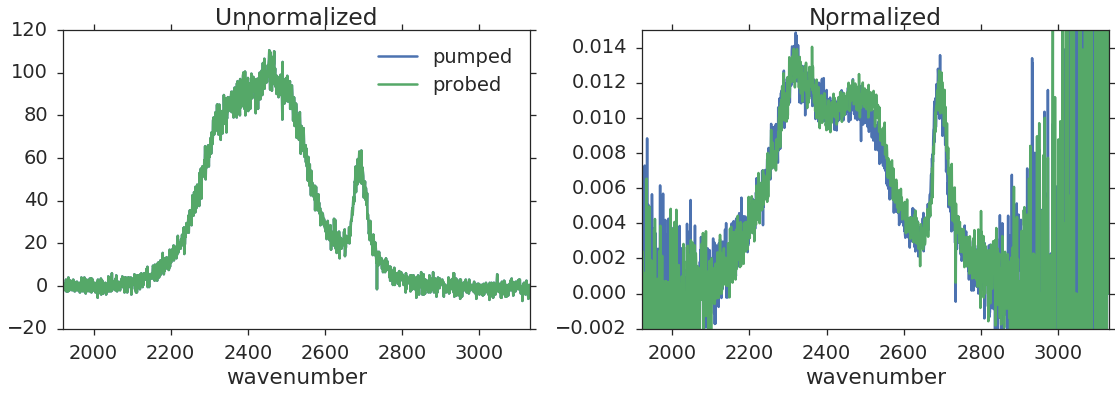

In [13]:
ipyw.interact(plot_norm_update, pp_delay=w_ts0_ppdelay1)

# Spectra Over Time

In [14]:
%%capture
#w_ts0_ppdelay2 = ipyw.SelectionSlider(options=list(ts0.pp_delays), value=0, continuous_update=False)
roi = slice(2200,2800)

def plot_compare_update(pp_delay):
    #fig_normalize.suptitle(pp_delay)
    #[ax.clear() for ax in ax_normalize]
    #ts0.df.loc[pp_delay]["spec_0"][roi].plot(ax=ax_normalize[0])        
    #ts0.df.loc[pp_delay]["spec_1"][roi].plot(ax=ax_normalize[1])
    #plt.ylim(-0.002, 0.015)
    for i in range(ts0.df['spec_0'].shape[1]):
        data = ts0.df.loc[w_ts0_ppdelay2.value, "spec_0"][roi].iloc[:,i]
        ax_compare[0].lines[i].set_ydata(data)
        data = ts0.df.loc[w_ts0_ppdelay2.value, "spec_1"][roi].iloc[:,i]
        ax_compare[1].lines[i].set_ydata(data)
    
    display(fig_compare)
    

fig_compare, ax_compare = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ts0.df.loc[w_ts0_ppdelay2.value, "spec_0"][roi].plot(ax=ax_compare[0])        
ts0.df.loc[w_ts0_ppdelay2.value, "spec_1"][roi].plot(ax=ax_compare[1])
for ax, title in zip(ax_compare, ('spec_0', 'spec_1')):
    ax.set_title(title)
    for i in range(len(ax.lines)):
        ax.lines[i].set_label('run %i'%i)
    ax.legend()
plt.ylim(-0.002, 0.017)

(-0.002, 0.017)

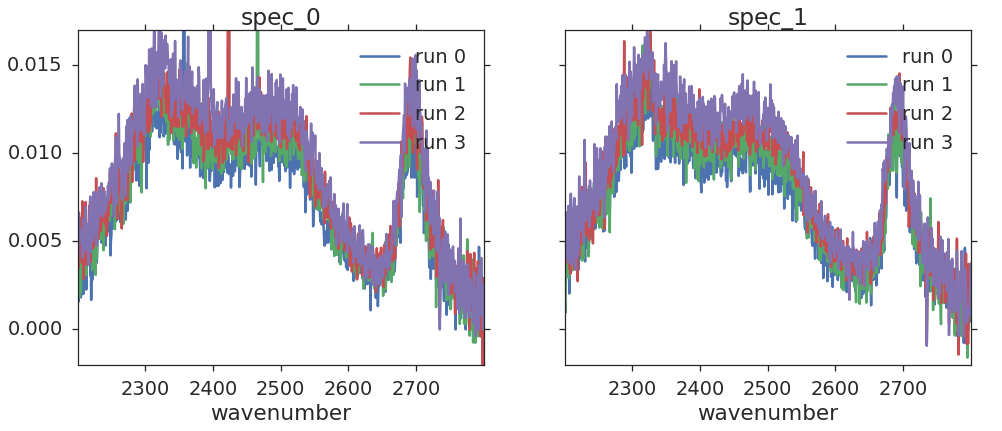

In [16]:
w_f0 = ipyw.interact(plot_compare_update, pp_delay=w_ts0_ppdelay2)
#display(w_f0)

## Smoothed

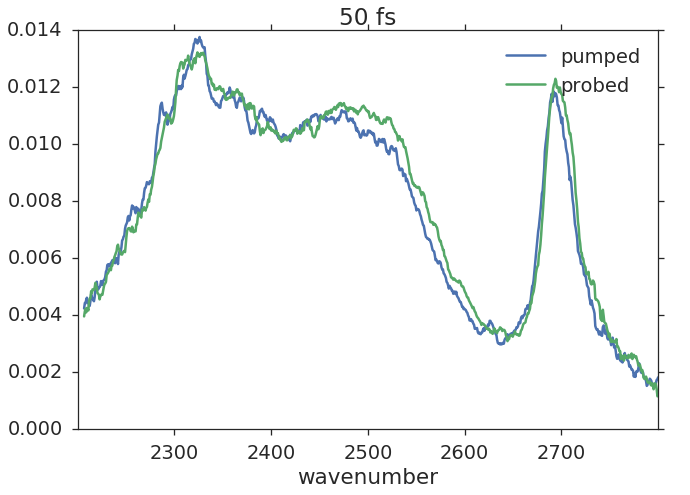

In [17]:
#w_ts0_ppdelay3 = ipyw.SelectionSlider(options=list(ts0.pp_delays), value=0, continuous_update=False)
roi = slice(2200,2800) # get this from the pump
def p3(pp_delay):
    ts0.pumped.loc[pp_delay][roi].rolling(10).mean().plot(label="pumped")
    ts0.probed.loc[pp_delay][roi].rolling(10).mean().plot(label="probed")
    #plt.ylim(0.001, 0.015)
    plt.title(str(pp_delay) + " fs")
    plt.legend()
    #plt.grid()

w_p3 = ipyw.interactive(p3, pp_delay=w_ts0_ppdelay3)
display(w_p3)
plt.show()

# Bleach Trace

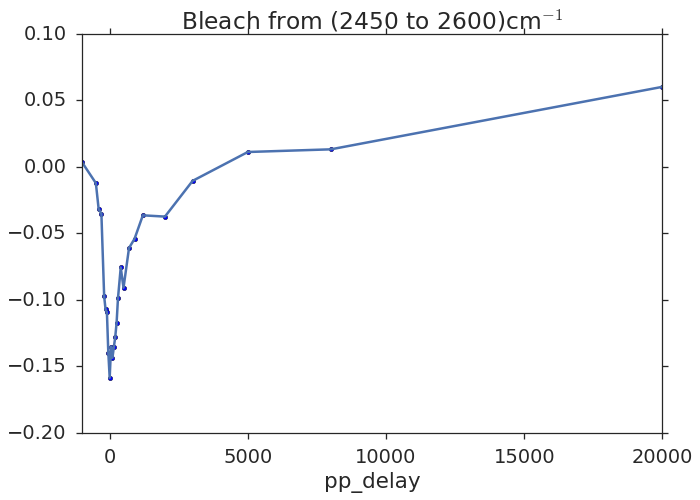

In [18]:
roi_slider_range = int(ts0.df.index.levels[1].min()), int(ts0.df.index.levels[1].max())
roi_slider = ipyw.IntRangeSlider(
    value = (2450, 2600),
    min = roi_slider_range[0],
    max = roi_slider_range[1],
    continuous_update=False
)

def plot_bleach_trace(roi):
    tss = ts0.bleach.unstack(0)
    tss = tss[(tss.index > roi[0]) & (tss.index < roi[1])].sum()

    tss.plot()
    plt.scatter(tss.index, tss)
    plt.title(r"Bleach from (%i to %i)cm$^{-1}$"%(roi[0], roi[1]))
    
ipyw.interact(plot_bleach_trace, roi=roi_slider)
plt.show()